# Advanced Lane Finding

## Import

In [147]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Constants

In [148]:
image_shape = (1280, 720)

## Helper Functions

In [182]:
def test_image(name):
    test_image_path = './test_images/%s' % name
    return mpimg.imread(test_image_path, cv2.IMREAD_COLOR)

def show_image(image):
    plt.imshow(image)
    
def show_image_gray(image):
    plt.imshow(image, cmap='gray')

## 3. Camera Calibration

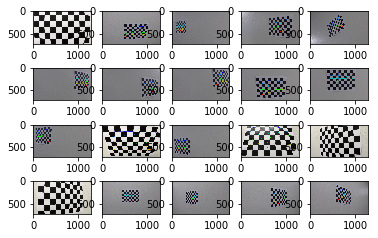

In [151]:
%matplotlib inline

nx = 9
ny = 6

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
object_points = np.zeros((ny * nx, 3), np.float32)
object_points[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
object_points_list = [] # 3d points in real world space
image_points_list = [] # 2d points in image plane.

# Find all calibration images
image_names = glob.glob('./camera_cal/calibration*.jpg')

# Parameters for display
figure =plt.figure()
num_images = len(image_names)
num_row = int(np.floor(np.sqrt(num_images)))
num_col = int(np.ceil(num_images / num_row))

for image_index in range(num_images):
    # Read image.
    image_name = image_names[image_index]
    image = mpimg.imread(image_name)
    
    # Since the shapes of the images are not all the same, crop the images for precision
    image = image[0:image_shape[1], 0:image_shape[0]]
    
    # Transform image to grayscale.
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners.
    ret, corners = cv2.findChessboardCorners(gray_image, (9,6), None)
    
    if ret:
        # Append object points and image points.
        object_points_list.append(object_points)
        image_points_list.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(image, (9,6), corners, ret)

    # Draw image
    figure.add_subplot(num_row, num_col, image_index + 1)
    plt.imshow(image)
    
# Calculate calibration.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points_list, image_points_list, image_shape, None, None)

## Image Undistortion

In [152]:
def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

## Test Image Undistortion

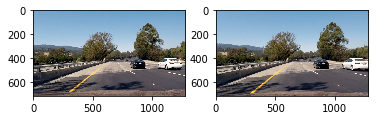

In [184]:
%matplotlib inline

test4 = test_image('test4.jpg')
test4_undistorted = undistort(test4)

figure = plt.figure()
figure.add_subplot(1, 2, 1)
plt.imshow(test4)
figure.add_subplot(1, 2, 2)
plt.imshow(test4_undistorted)

## HLS Color Space

In [185]:
def image_to_s_channel(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]

## Test Color Space

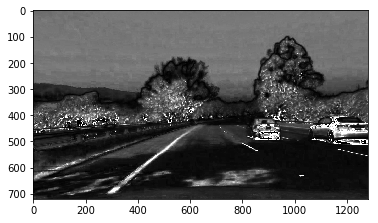

In [186]:
show_image_gray(image_to_s_channel(undistort(test_image('test4.jpg'))))

## Thresholding Lane Lines

In [200]:
def binary_output(matrix, threshold):
    binary = np.zeros_like(matrix)
    binary[(matrix >= threshold[0]) & (matrix < threshold[1])] = 1
    return binary


def scale(matrix):
    return matrix / np.max(matrix) * 255


class Thresholding():
    def __init__(self,
                 sobel_kernel=3,
                 threshold_magnitude_min=0, threshold_magnitude_max=255,
                 threshold_direction_min=0, threshold_direction_max=np.pi / 2,
                 threshold_color_min=0, threshold_color_max=255):
        self.sobel_kernel = sobel_kernel
        self.threshold_magnitude_min = threshold_magnitude_min
        self.threshold_magnitude_max = threshold_magnitude_max
        self.threshold_direction_min = threshold_direction_min
        self.threshold_direction_max = threshold_direction_max
        self.threshold_color_min = threshold_color_min
        self.threshold_color_max = threshold_color_max
    
    def threshold(self, gray_image):
        combined_threshold = np.zeros_like(gray_image)
        mag_binary = self.magnitude_threshold(gray_image,
                                              threshold=(self.threshold_magnitude_min,
                                                         self.threshold_magnitude_max))
        dir_binary = self.direction_threshold(gray_image,
                                              threshold=(self.threshold_direction_min,
                                                         self.threshold_direction_max))
        color_binary = self.color_threshold(gray_image,
                                            threshold=(self.threshold_color_min,
                                                       self.threshold_color_max))
        
        combined_threshold[
            (((mag_binary == 1) & (dir_binary == 1)) | (color_binary == 1))
        ] = 1
        return combined_threshold
    
    def sobelx(self, gray_image):
        return cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)

    def sobely(self, gray_image):
        return cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)

    def magnitude_threshold(self, gray_image, threshold):
        sobel_magnitude = np.sqrt(
            self.sobelx(gray_image) ** 2 + self.sobely(gray_image) ** 2)
        return binary_output(scale(sobel_magnitude), threshold)

    def direction_threshold(self, gray_image, threshold):
        sobel_direction = np.arctan2(
            np.absolute(self.sobely(gray_image)),
            np.absolute(self.sobelx(gray_image)))
        return binary_output(sobel_direction, threshold)
    
    def color_threshold(self, gray_image, threshold):
        return binary_output(gray_image, threshold)


def threshold(image):
    return Thresholding(sobel_kernel=5,
                        threshold_magnitude_min=50, threshold_magnitude_max=199,
                        threshold_direction_min=0.7, threshold_direction_max=1.4,
                        threshold_color_min=160, threshold_color_max=255
                       ).threshold(image)
pipeline.add(threshold)

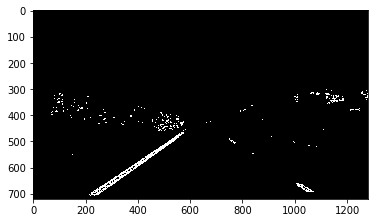

In [201]:
show_image_gray(threshold(image_to_s_channel(undistort(test_image('straight_lines1.jpg')))))

## Perspective Transform

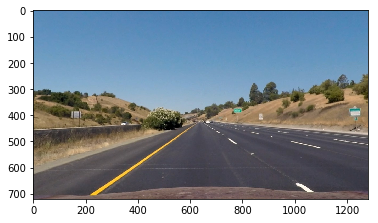

In [202]:
# Undistorted image with straight lines
%matplotlib inline

straight_line_image = mpimg.imread('./test_images/straight_lines1.jpg')
straight_line_image_undistorted = undistort(straight_line_image)
plt.imshow(straight_line_image_undistorted)
plt.imsave('./test_images/straight_lines1_undistorted.jpg', undistort(straight_line_image))

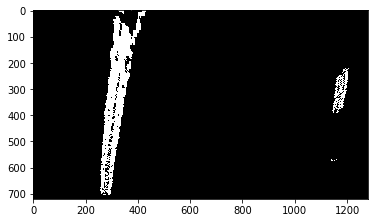

In [214]:
# Picked points manually
source_points = np.float32((
    (228, 704),  # bottom left
    (1059, 692), # bottom right
    (531, 496),  # top left
    (755, 496),  # top right
))

destination_points = np.float32((
    (228, 704),
    (1059, 692),
    (228, 200),
    (1059, 200),
))

transform_matrix = cv2.getPerspectiveTransform(source_points, destination_points)
inverse_transform_matrix = cv2.getPerspectiveTransform(destination_points, source_points)

def warp(gray_image):
    return cv2.warpPerspective(gray_image, transform_matrix, (1280, 720), flags=cv2.INTER_LINEAR)

def unwarp(gray_image):
    return cv2.warpPerspective(gray_image, inverse_transform_matrix, (1280, 720), flags=cv2.INTER_LINEAR)

binary_warped = warp(threshold(image_to_s_channel(undistort(test_image('test6.jpg')))))
plt.imshow(binary_warped, cmap='gray')

## Find Lane Lines
### Peaks in a Histogram

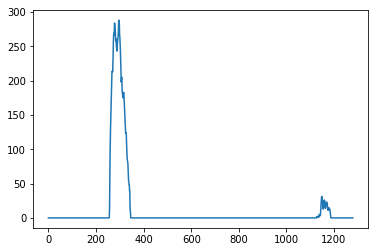

In [215]:
histogram = np.sum(binary_warped[image_shape[1]//2:,:], axis=0)
plt.plot(histogram)

### Line Class

In [226]:
class Line:
    def __init__(self, fit):
        self.fit = fit

### Sliding Window

(720, 0)

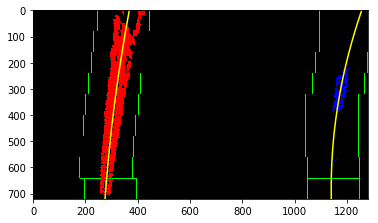

In [216]:
# Following code is modified from Udacity class material

def sliding_window
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(2, 720)


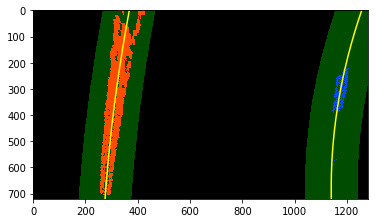

In [221]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

print(np.vstack([left_fitx, ploty]).shape)

(1, 1440, 2)


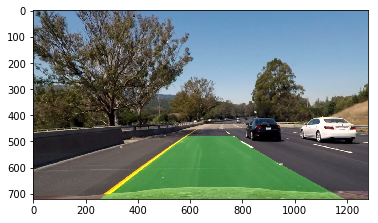

In [225]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, inverse_transform_matrix, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistort(test_image('test6.jpg')), 1, newwarp, 0.3, 0)
plt.imshow(result)